In [10]:
import batting_statlines as stat 
import pandas as pd 
import matplotlib.pyplot as plt
from collections import namedtuple

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [11]:
fangraphs_board = pd.read_csv('pitching.csv').drop(columns='playerid')
fangraphs_board.rename(columns={'Season': 'yearID', 'Name': 'name', 'Team': 'teamID'}, inplace = True)
fangraphs_board = stat.order_by(fangraphs_board, ['yearID', 'teamID'], True)
fangraphs_board = fangraphs_board[fangraphs_board.teamID != '- - -']
for col in ['K%', 'BB%']:
    fangraphs_board[col] = fangraphs_board[col].replace('%', '', regex=True)
    fangraphs_board[col] = pd.to_numeric(fangraphs_board[col])


In [12]:
fangraphs_board.columns

Index(['yearID', 'name', 'teamID', 'W', 'L', 'IP', 'WHIP', 'K%', 'BB%', 'HR/9',
       'ERA', 'FIP', 'ERA-', 'FIP-', 'K/BB+', 'WHIP+', 'K%+', 'BB%+', 'WAR'],
      dtype='object')

## Here We Go!

The first thing that I want to do, is to group everybody into teams. In order to do this analysis, I'm going to be looking at Johnson and Schilling's numbers together as a single aggregate. I think that would be the best, becuase I'm going to compare them to other top 2 pitchers on teams so we're really comparing "groups" of players rather than individual players.

### The Plan

What I plan on doing is first, create the aggregate values for each column, for the top two pitchers in a team each year. After I do that I want to rank each pair of staff aces for each statistic. From there, create an average score for how they rank in each statistic to find the most "dominant" pairing of pitchers. Then, look across each year and see who has the highest "dominance" score.

In [13]:
# Creates a df of mean values of the top 2 pitchers by WAR for each team in each season
top2_aggs = fangraphs_board[fangraphs_board.yearID != 2020].sort_values('WAR', ascending=False).groupby(['teamID', 'yearID']).head(2).sort_values(['yearID', 'teamID'])
top2_aggs = top2_aggs.drop(columns='name').groupby(['yearID', 'teamID']).mean().reset_index()
# Creates a df of the names for each team split
names = fangraphs_board.sort_values('WAR', ascending=False).groupby(['yearID', 'teamID']).head(2).sort_values(['yearID', 'teamID', 'name']).reset_index(drop=True)
names = names.groupby(['yearID', 'teamID']).name.apply(tuple).reset_index().rename(columns={'name': 'tandem'})
top2_aggs = top2_aggs.merge(names, on=['yearID', 'teamID'])
# Filtering out teams with only one qualified pitcher for the season
top2_aggs = top2_aggs[top2_aggs.tandem.apply(lambda x: len(x) > 1)]

# Some for some columns, larger numbers = better (counting_cols). For others, smaller = better (non_counting_cols)
counting_cols = ['yearID', 'teamID', 'tandem', 'W', 'IP', 'K%', 'K/BB+', 'K%+', 'WAR']
non_counting_cols = ['yearID', 'teamID','tandem']
for col in top2_aggs.columns.tolist():
    if (col not in counting_cols) and (col not in ['yearID', 'teamID']) :
        non_counting_cols.append(col)

# Creates ranking for columns with counting stats
counting_df = top2_aggs.loc[:, counting_cols].set_index(['yearID', 'teamID', 'tandem']).groupby('yearID').rank(method='average', ascending=False).reset_index()
# Creates ranking for columns where lower numbers are better
non_counting_df = top2_aggs.loc[:, non_counting_cols].set_index(['yearID', 'teamID', 'tandem']).groupby('yearID').rank(method='average', ascending=True).reset_index()
# Merges above df, creates a composite score which is the average of each rank. Lower is better
ranked = counting_df.merge(non_counting_df, on=['yearID', 'teamID', 'tandem'])[top2_aggs.columns.tolist()]
ranked['composite'] = ranked.filter(regex='[^yearIDteamIDtandem]').mean(axis=1)

# Sort ranked by lowest composite score, dropping any team with only one qualified pitcher
ranked_sorted = ranked.sort_values('composite')
# Count of team appearances in the top 20 most dominant seasons
top20_appearances_team = ranked_sorted.head(20).groupby('teamID').composite.count().reset_index().rename(columns={'composite': 'Count'}).sort_values('Count').reset_index(drop=True)
# Count of tandem appearances in the top 20 most dominant seasons
top20_appearances_tandem = ranked_sorted.head(20).groupby(['teamID', 'tandem']).composite.count().reset_index().rename(columns={'composite': 'Count'}).sort_values('Count').reset_index(drop=True)
tuples = ranked_sorted.head(20).groupby(['teamID', 'tandem']).yearID.apply(tuple).reset_index()
top20_appearances_tandem = top20_appearances_tandem.merge(tuples, on=['teamID', 'tandem'])


## The Results

Wow! There definitely are a lot of teams who were dominant over the years. The season I thought was good (only because they won the world series haha) was the 20th,they did better the year after! They together have TWO top 20 performances among over 1786 other teams is just ridiculous. Only 7 of the 30 teams in the sample have had multiple teams in the top 20. I think what I want to do next is look at groups of pairings. So, Schilling and Johnson would have had about a 2.5ish average composite score in those two top 20 years. I wonder what the score would be for their entire time together on the diamondbacks? What are some other electric duos that stuck together for a while. Time to find out!\
\
\
Some graphs bruh:

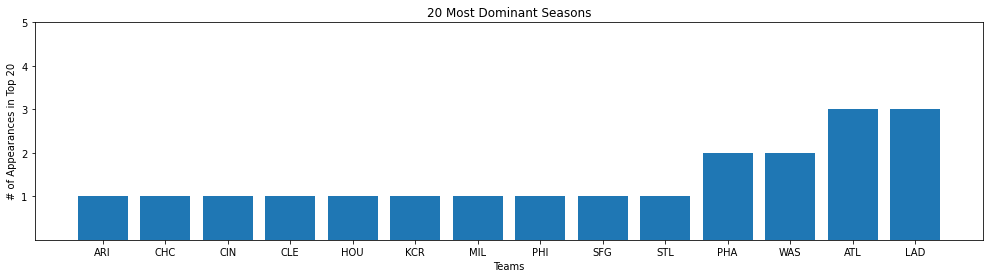

In [14]:
# Bar Graph of each top 20 team's number of appearances in the top 20
y_vals = []
for team in top20_appearances_team.index:
    y_vals.append(top20_appearances_team.loc[team, "Count"])

plt.figure(figsize=(len(top20_appearances_team.index) + 3, 4))
ax = plt.subplot(1, 1, 1)
x_values = range(len(top20_appearances_team.teamID))
plt.bar(x_values, y_vals)
plt.title("20 Most Dominant Seasons")
plt.xlabel('Teams')
plt.ylabel('# of Appearances in Top 20')
ax.set_xticks(x_values)
ax.set_xticklabels(top20_appearances_team.teamID.tolist())
ax.set_yticks(range(1, 6))
plt.savefig('team.png', facecolor='White')
plt.show()


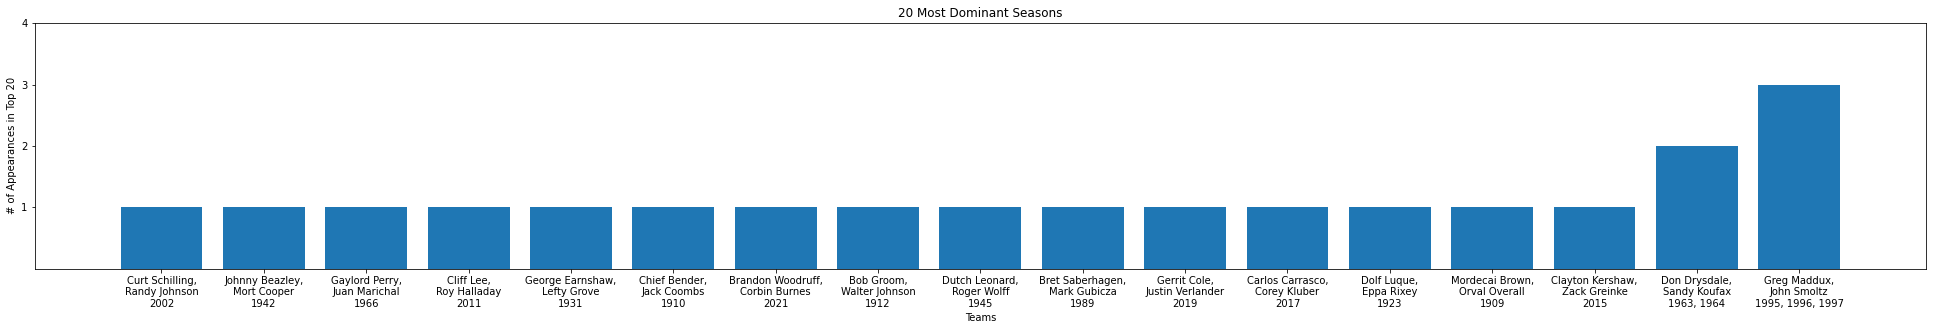

In [16]:
# Bar Graph of each top 20 team's number of appearances in the top 20
plt.figure(figsize=(len(top20_appearances_tandem.index) + 10, 4))
ax = plt.subplot(1, 1, 1)
plt.tight_layout()
y_vals = top20_appearances_tandem.Count.tolist()
x_values = range(len(top20_appearances_tandem.tandem))
formatted_labels = []
for row in top20_appearances_tandem.itertuples():
    s = f'{row.tandem[0]},\n{row.tandem[1]}\n'
    s2 = ", ".join(str(i) for i in sorted(row.yearID))
    formatted_labels.append(s + s2)


plt.bar(x_values, y_vals)
plt.title("20 Most Dominant Seasons")
plt.xlabel('Teams')
plt.ylabel('# of Appearances in Top 20')
ax.set_xticks(x_values)
ax.set_xticklabels(formatted_labels)
ax.set_yticks(range(1, 5))
plt.savefig('tandem.png', facecolor='White')
plt.show()


# Next, and Probably Last

Now that I have the tandem split included, I want to know <strong>who was dominant the longest</strong>? \
Earlier I applied the max_year, min_year, and stretch columns too soon. In order to know who was most dominant, I want to know who has the greatest stretch while being FIRST in the league for composite score.

In [19]:
dominance = ranked.sort_values('composite').groupby('yearID').head(1)


# Creates a max_year, min_year, and length for each tandem split that I call stretch (for stretch of dominance)
max_year = dominance.groupby(['teamID', 'tandem']).yearID.max().reset_index().rename(columns={'yearID': 'max_year'})
min_year = dominance.groupby(['teamID', 'tandem']).yearID.min().reset_index().rename(columns={'yearID': 'min_year'})
stretch = dominance.groupby(['teamID', 'tandem']).yearID.count().reset_index().rename(columns={'yearID': 'stretch'})
dominance = dominance.merge(stretch.merge(pd.merge(max_year, min_year, on=['teamID', 'tandem']), on=['teamID', 'tandem']), on=['teamID', 'tandem'])
dominance = dominance[['yearID', 'teamID', 'tandem', 'stretch', 'min_year', 'max_year', 'composite']]
dominance = dominance[dominance.stretch >= 2].sort_values(['stretch', 'yearID'])
dominance = dominance.drop_duplicates(subset='tandem')

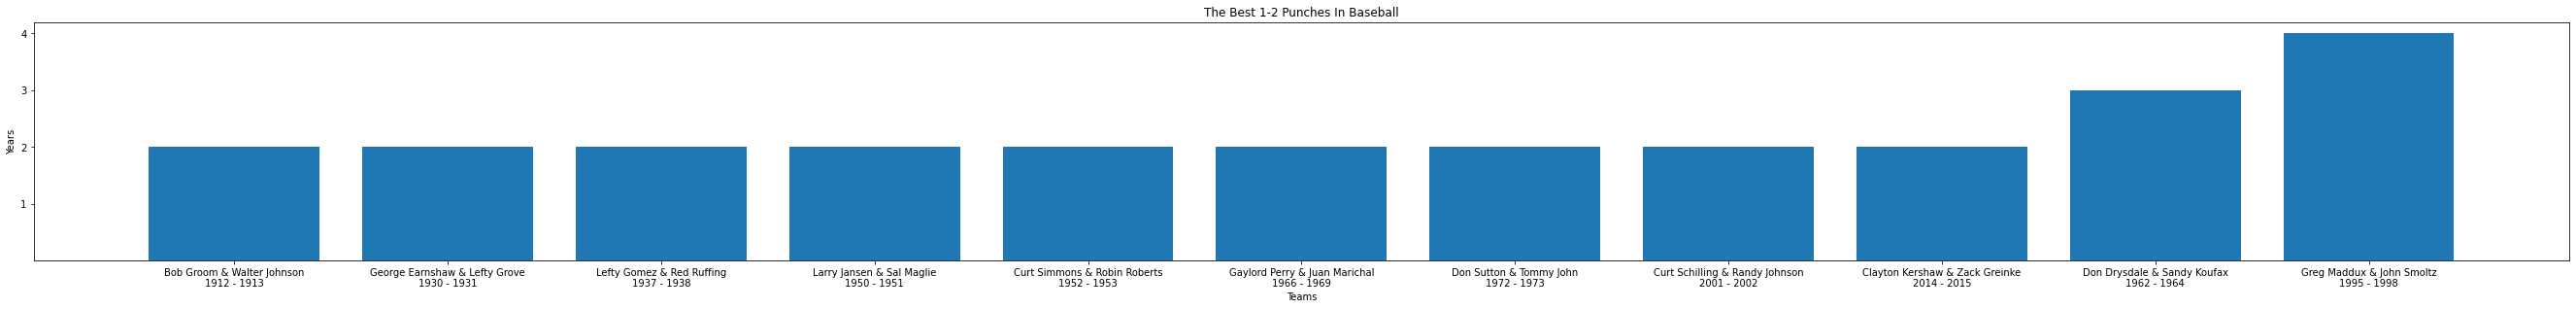

In [18]:
plt.figure(figsize=(len(top20_appearances_tandem.index) + 20, 4))
ax = plt.subplot(1, 1, 1)
plt.tight_layout()
y_vals = dominance.stretch.tolist()
x_values = range(len(dominance.tandem))
labels = []
for row in dominance.itertuples():
    labels.append(f'{row.tandem[0]} & {row.tandem[1]}\n{row.min_year} - {row.max_year}')


plt.bar(x_values, y_vals)
plt.title("The Best 1-2 Punches In Baseball")
plt.xlabel('Teams')
plt.ylabel('Years')
ax.set_xticks(x_values)
ax.set_xticklabels(labels)
ax.set_yticks(range(1, dominance.stretch.max() + 1))
plt.savefig('dominance.png', facecolor='White')
plt.show()


This project was started a *loooooong* time ago so I'm glad I've finished.\
I should've thought about Maddux and Smoltz as potential dominators, and I am not surprised that only 9 tandems from across the league have had back to back seasons of dominance. Now, this isn't all the data and I can update it with newer numbers but it has been good practice and interesting to see.\
\
For now, I will call it good on this project.